In [2]:
!pip install pandarallel
!pip install rouge-score
!pip install evaluate
!pip install datasets

**Imports**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import requests
import zipfile
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from collections import Counter
import random
import time
import os
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
USE_PANDARALLEL = True

from rouge_score import rouge_scorer

nltk.download('punkt_tab')
nltk.download('stopwords')

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

 **Configuration & Preprocessing Setup🚀**

In [4]:
class Config:
    SEED = 42
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Task A: Data & Preprocessing
    TRAIN_FILE = '/kaggle/input/dataaaaa/train.csv'
    TEST_FILE  = '/kaggle/input/dataaaaa/test.csv'
    VAL_SET_SIZE = 500
    PREPROCESS_TITLES_RNN = True

    # Task B: RNN Model Parameters
    MIN_TOKEN_FREQ_PERCENT = 0.01
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 400
    NUM_LAYERS = 1
    DROPOUT = 0.3
    ENCODER_BIDIRECTIONAL = True

    BATCH_SIZE_RNN = 16
    NUM_EPOCHS_RNN = 5
    LEARNING_RATE_RNN = 0.0005
    TEACHER_FORCING_RATIO = 0.7
    GRAD_CLIP = 1.0

    # Decoding and Evaluation
    MAX_GEN_LEN_RNN = 25

    GLOVE_EMBEDDING_DIM = 100
    GLOVE_DIR = "./glove_data"

    # For T5 fine-tuning (C1)
    T5_MODEL_NAME = "google/t5-small"
    MAX_SOURCE_LENGTH = 512
    MAX_TARGET_LENGTH = 64
    TRAIN_BATCH_SIZE = 8
    EVAL_BATCH_SIZE = 8
    NUM_EPOCHS = 3
    LEARNING_RATE = 5e-5

    # For FLAN-T5 prompting (C2)
    FLAN_BASE_MODEL = "google/flan-t5-base"
    FLAN_LARGE_MODEL = "google/flan-t5-large"
    MAX_SOURCE_LENGTH_PROMPT = 512
    MAX_TARGET_LENGTH_PROMPT = 64
    # Prompt variants for zero-shot generation:
    PROMPTS = [
      "Generate a concise title for the following article: ",
      "What would be a good title for this text? "
    ]

config = Config()
random.seed(config.SEED)
np.random.seed(config.SEED)
torch.manual_seed(config.SEED)
if config.DEVICE == torch.device("cuda"):
    torch.cuda.manual_seed(config.SEED)

PAD_TOKEN = '<PAD>'
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'
UNK_TOKEN = '<UNK>'
special_tokens = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
NLTK_AVAILABLE = True

**Dataset & Preprocessing Functions**

In [5]:
def preprocess_text(text):
    if not NLTK_AVAILABLE or not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.encode('ascii', errors='ignore').decode()
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    tokens = [stemmer.stem(word) for word in tokens]
    processed_text = ' '.join(tokens)
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()
    return processed_text

def preprocess_title(title):
    if not isinstance(title, str):
        return ""
    title = title.lower()
    title = title.encode('ascii', errors='ignore').decode()
    title = re.sub(r'[^\w\s]', ' ', title)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

def build_vocab(texts, min_freq_percent, doc_count):
    all_tokens = []
    for text in texts:
        tokens = text.split()
        all_tokens.extend(tokens)
    token_freq = Counter(all_tokens)
    min_freq = doc_count * min_freq_percent
    vocab = {token: idx for idx, token in enumerate(special_tokens)}
    for token, freq in token_freq.items():
        if freq >= min_freq:
            vocab[token] = len(vocab)
    inv_vocab = {idx: token for token, idx in vocab.items()}
    print(f"Built RNN Vocabulary size: {len(vocab)} (tokens >= {min_freq:.2f} frequency)")
    return vocab, inv_vocab

def text_to_seq(text, vocab, add_sos_eos=True):
    unk_idx = vocab[UNK_TOKEN]
    sos_idx = vocab[SOS_TOKEN]
    eos_idx = vocab[EOS_TOKEN]
    tokens = text.split()
    seq = [vocab.get(token, unk_idx) for token in tokens]
    if add_sos_eos:
        seq = [sos_idx] + seq + [eos_idx]
    if not seq and add_sos_eos:
        return [sos_idx, eos_idx]
    if not seq and not add_sos_eos:
        return [unk_idx]
    return seq

def seq_to_text(seq, inv_vocab):
    pad_idx = special_tokens.index(PAD_TOKEN)
    sos_idx = special_tokens.index(SOS_TOKEN)
    eos_idx = special_tokens.index(EOS_TOKEN)
    tokens = []
    for idx in seq:
        token_idx = idx.item() if isinstance(idx, torch.Tensor) else idx
        if token_idx in [pad_idx, sos_idx]:
            continue
        if token_idx == eos_idx:
            break
        tokens.append(inv_vocab.get(token_idx, UNK_TOKEN))
    return " ".join(tokens)

class WikiDataset(Dataset):
    def __init__(self, df, vocab, title_col='clean_title', text_col='clean_text'):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.title_col = title_col
        self.text_col = text_col
        if text_col not in df.columns or title_col not in df.columns:
            raise ValueError(f"Required columns '{text_col}' or '{title_col}' not in DataFrame.")
        print(f"WikiDataset initialized with {len(self.df)} samples.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        encoder_text = self.df.loc[idx, self.text_col]
        decoder_text = self.df.loc[idx, self.title_col]
        encoder_seq = text_to_seq(encoder_text, self.vocab, add_sos_eos=False)
        decoder_seq = text_to_seq(decoder_text, self.vocab, add_sos_eos=True)
        return torch.tensor(encoder_seq), torch.tensor(decoder_seq)

def collate_fn(batch, pad_idx):
    enc_seqs, dec_seqs = zip(*batch)
    enc_lengths = torch.tensor([len(seq) for seq in enc_seqs], dtype=torch.long)
    dec_lengths = torch.tensor([len(seq) for seq in dec_seqs], dtype=torch.long)
    enc_padded = nn.utils.rnn.pad_sequence(enc_seqs, batch_first=True, padding_value=pad_idx)
    dec_padded = nn.utils.rnn.pad_sequence(dec_seqs, batch_first=True, padding_value=pad_idx)
    return enc_padded, dec_padded, enc_lengths, dec_lengths


**Task A: Data Loading & Preprocessing**

In [6]:
task_a_start = time.time()
print("\n Running Task A: Data Loading & Preprocessing ")

print(f"Loading training data from: {config.TRAIN_FILE}")
df = pd.read_csv(config.TRAIN_FILE, on_bad_lines='skip', engine='python',encoding='latin-1')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(f"Loading test data from: {config.TEST_FILE}")
test_df_raw = pd.read_csv(config.TEST_FILE,encoding='latin-1')
test_df_raw = test_df_raw.loc[:, ~test_df_raw.columns.str.contains('^Unnamed')]

# Drop rows with missing or empty text/title
df.dropna(subset=['text', 'title'], inplace=True)
df = df[df['text'].str.strip().astype(bool)]
df = df[df['title'].str.strip().astype(bool)]
df.reset_index(drop=True, inplace=True)
train_df, validation_df = train_test_split(df, test_size=config.VAL_SET_SIZE, random_state=config.SEED, shuffle=True)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

test_df = test_df_raw.copy()
test_df.dropna(subset=['text', 'title'], inplace=True)
test_df = test_df[test_df['text'].str.strip().astype(bool)]
test_df = test_df[test_df['title'].str.strip().astype(bool)]
test_df.reset_index(drop=True, inplace=True)
print(f"Data sizes - Train: {len(train_df)}, Valid: {len(validation_df)}, Test: {len(test_df)}")

apply_func = 'parallel_apply' if USE_PANDARALLEL else 'apply'
print(f"Preprocessing text using {apply_func}...")
train_df['clean_text'] = getattr(train_df['text'], apply_func)(preprocess_text)
validation_df['clean_text'] = getattr(validation_df['text'], apply_func)(preprocess_text)
test_df['clean_text'] = getattr(test_df['text'], apply_func)(preprocess_text)

if config.PREPROCESS_TITLES_RNN:
    print(f"Preprocessing titles using {apply_func}...")
    train_df['clean_title'] = getattr(train_df['title'], apply_func)(preprocess_title)
    validation_df['clean_title'] = getattr(validation_df['title'], apply_func)(preprocess_title)
    test_df['clean_title'] = getattr(test_df['title'], apply_func)(preprocess_title)
else:
    train_df['clean_title'] = train_df['title']
    validation_df['clean_title'] = validation_df['title']
    test_df['clean_title'] = test_df['title']

# Remove any rows with empty cleaned text
train_df = train_df[train_df['clean_text'].str.len() > 0].reset_index(drop=True)
validation_df = validation_df[validation_df['clean_text'].str.len() > 0].reset_index(drop=True)
test_df = test_df[test_df['clean_text'].str.len() > 0].reset_index(drop=True)
print(f"Final sizes after cleaning - Train: {len(train_df)}, Valid: {len(validation_df)}, Test: {len(test_df)}")
task_a_end = time.time()
print(f"preprocessing Finished in {task_a_end - task_a_start:.2f} seconds \n")



 Running Task A: Data Loading & Preprocessing 
Loading training data from: /kaggle/input/dataaaaa/train.csv
Loading test data from: /kaggle/input/dataaaaa/test.csv
Data sizes - Train: 17049, Valid: 500, Test: 100
Preprocessing text using parallel_apply...


Preprocessing titles using parallel_apply...


Final sizes after cleaning - Train: 17049, Valid: 500, Test: 100
preprocessing Finished in 199.70 seconds 



**Prepare DataLoaders**

In [7]:
print("\n--- Building RNN Vocabulary and DataLoaders ---")
vocab_rnn, inv_vocab_rnn = build_vocab(train_df['clean_text'], config.MIN_TOKEN_FREQ_PERCENT, len(train_df))
vocab_size_rnn = len(vocab_rnn)
pad_idx_rnn = vocab_rnn[PAD_TOKEN]
sos_idx_rnn = vocab_rnn[SOS_TOKEN]
eos_idx_rnn = vocab_rnn[EOS_TOKEN]

title_col_rnn = 'clean_title' if config.PREPROCESS_TITLES_RNN else 'title'
train_dataset_rnn = WikiDataset(train_df, vocab_rnn, title_col=title_col_rnn)
valid_dataset_rnn = WikiDataset(validation_df, vocab_rnn, title_col=title_col_rnn)
test_dataset_rnn  = WikiDataset(test_df, vocab_rnn, title_col=title_col_rnn)
collate_wrapper_rnn = lambda batch: collate_fn(batch, pad_idx_rnn)
train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=config.BATCH_SIZE_RNN, shuffle=True, collate_fn=collate_wrapper_rnn, drop_last=True)
valid_loader_rnn = DataLoader(valid_dataset_rnn, batch_size=config.BATCH_SIZE_RNN, shuffle=False, collate_fn=collate_wrapper_rnn)
test_loader_rnn  = DataLoader(test_dataset_rnn, batch_size=config.BATCH_SIZE_RNN, shuffle=False, collate_fn=collate_wrapper_rnn)
print("RNN DataLoaders ready.")


--- Building RNN Vocabulary and DataLoaders ---
Built RNN Vocabulary size: 9497 (tokens >= 170.49 frequency)
WikiDataset initialized with 17049 samples.
WikiDataset initialized with 500 samples.
WikiDataset initialized with 100 samples.
RNN DataLoaders ready.


**Utility function to download and extract GloVe embeddings**

In [8]:
def download_glove(embedding_dim, glove_dir):
    os.makedirs(glove_dir, exist_ok=True)
    glove_zip = os.path.join(glove_dir, "glove.6B.zip")
    if not os.path.exists(glove_zip):
        print("Downloading GloVe embeddings...")
        url = "https://nlp.stanford.edu/data/glove.6B.zip"
        r = requests.get(url, stream=True)
        total_size = int(r.headers.get("content-length", 0))
        with open(glove_zip, "wb") as f, tqdm(
            total=total_size, unit="B", unit_scale=True, desc="Downloading GloVe"
        ) as bar:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    bar.update(len(chunk))
        print("GloVe download complete.")
    glove_txt = os.path.join(glove_dir, f"glove.6B.{embedding_dim}d.txt")
    if not os.path.exists(glove_txt):
        print("Extracting GloVe embeddings...")
        with zipfile.ZipFile(glove_zip, "r") as zip_ref:
            zip_ref.extractall(glove_dir)
        print("Extraction complete.")
    return glove_txt


**Task B :Model Definitions & Improvements**

In [9]:
# Basic EncoderRNN with load_embeddings setter added (Improvement 1)
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, pad_idx, bidirectional):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0,
                          bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional
        if bidirectional:
            self.fc_hidden = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, input_seqs, seq_lengths):
        embedded = self.dropout(self.embedding(input_seqs))
        packed = nn.utils.rnn.pack_padded_sequence(embedded, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        if self.bidirectional:
            hidden_fwd = hidden[-2, :, :]
            hidden_bwd = hidden[-1, :, :]
            hidden_cat = torch.cat((hidden_fwd, hidden_bwd), dim=1)
            hidden_reduced = torch.tanh(self.fc_hidden(hidden_cat))
            return hidden_reduced.unsqueeze(0)
        else:
            return hidden


     #Improvement 1: load GloVe embeddings via a setter function.
    def load_embeddings(self, glove_dir, vocab, embedding_dim):
        glove_txt = download_glove(embedding_dim, glove_dir)
        print(f"Loading GloVe embeddings from: {glove_txt}")
        embeddings_index = {}
        with open(glove_txt, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                if len(values) == embedding_dim + 1:
                    word = values[0]
                    vector = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = vector
        weight_matrix = self.embedding.weight.data.clone()
        for word, idx in vocab.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                weight_matrix[idx] = torch.tensor(embedding_vector)
        self.embedding.weight.data.copy_(weight_matrix)
        print("GloVe embeddings loaded.")

# Improvement 2: Hierarchical Encoder (HierEncoderRNN)
class HierEncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, pad_idx, bidirectional, chunk_size=50):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.word_rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                               batch_first=True, dropout=dropout if num_layers > 1 else 0,
                               bidirectional=bidirectional)
        self.chunk_size = chunk_size
        self.sentence_rnn = nn.GRU(hidden_dim * (2 if bidirectional else 1), hidden_dim, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

     # Improvement 1: load GloVe embeddings via a setter function.
    def load_embeddings(self, glove_dir, vocab, embedding_dim):
        glove_txt = download_glove(embedding_dim, glove_dir)
        print(f"Loading GloVe embeddings from: {glove_txt}")
        embeddings_index = {}
        with open(glove_txt, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                if len(values) == embedding_dim + 1:
                    word = values[0]
                    vector = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = vector
        weight_matrix = self.embedding.weight.data.clone()
        for word, idx in vocab.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                weight_matrix[idx] = torch.tensor(embedding_vector)
        self.embedding.weight.data.copy_(weight_matrix)
        print("GloVe embeddings loaded.")


    def forward(self, input_seqs, seq_lengths):
        embedded = self.dropout(self.embedding(input_seqs))
        batch_size, seq_len, _ = embedded.size()
        chunks = []
        for i in range(0, seq_len, self.chunk_size):
            chunk = embedded[:, i:i+self.chunk_size, :]
            output, hidden = self.word_rnn(chunk)
            if self.bidirectional:
                hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
            else:
                hidden = hidden[-1]
            chunks.append(hidden.unsqueeze(1))
        chunks_tensor = torch.cat(chunks, dim=1)
        sentence_output, sentence_hidden = self.sentence_rnn(chunks_tensor)
        return sentence_hidden

# Basic DecoderRNN
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=0)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_step, hidden):
        input_step = input_step.unsqueeze(1)
        embedded = self.dropout(self.embedding(input_step))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden

# Improvement 3: 2-Layer Decoder (Decoder2RNN)
class Decoder2RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.2, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_step, hidden):
        input_step = input_step.unsqueeze(1)
        embedded = self.dropout(self.embedding(input_step))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden

# Modified Seq2seqRNN to choose encoder/decoder and to support beam search.
class Seq2seqRNN(nn.Module):
    def __init__(self, encoder, decoder, device, vocab, pad_idx, sos_idx, eos_idx, decode_method='greedy'):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.vocab = vocab
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.decode_method = decode_method  # 'greedy' or 'beam'

    def _match_decoder_hidden(self, encoder_hidden):
        num_decoder_layers = self.decoder.rnn.num_layers
        num_encoder_layers_out = encoder_hidden.size(0)
        if num_encoder_layers_out == num_decoder_layers:
            return encoder_hidden.contiguous()
        elif num_encoder_layers_out == 1 and num_decoder_layers > 1:
            return encoder_hidden.repeat(num_decoder_layers, 1, 1).contiguous()
        elif num_encoder_layers_out > 1 and num_decoder_layers == 1:
            return encoder_hidden[-1,:,:].unsqueeze(0).contiguous()
        else:
            raise ValueError("Mismatch between encoder and decoder layers.")

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        encoder_hidden_raw = self.encoder(src, src_lengths)
        decoder_hidden = self._match_decoder_hidden(encoder_hidden_raw)
        input_step = trg[:, 0]  # SOS token
        for t in range(1, trg_len):
            output, decoder_hidden = self.decoder(input_step, decoder_hidden)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_step = trg[:, t] if teacher_force else top1
        return outputs

    def _greedy_decode(self, batch_size, max_len, decoder_hidden):
        input_step = torch.tensor([self.sos_idx] * batch_size, device=self.device)
        outputs_indices = [[] for _ in range(batch_size)]
        finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)
        for _ in range(max_len):
            output, decoder_hidden = self.decoder(input_step, decoder_hidden)
            top1 = output.argmax(1)
            input_step = top1
            for i in range(batch_size):
                if not finished[i]:
                    token = top1[i].item()
                    if token == self.eos_idx:
                        finished[i] = True
                    else:
                        outputs_indices[i].append(token)
            if finished.all():
                break
        return outputs_indices

    def _beam_search_decode(self, batch_size, max_len, beam_width, initial_hidden):
        all_outputs = []
        for b in range(batch_size):
            decoder_hidden_b = initial_hidden[:, b:b+1, :].contiguous()
            beams = [([self.sos_idx], decoder_hidden_b, 0.0)]
            finished_beams = []
            for _ in range(max_len):
                new_candidates = []
                active_beams = []
                if len(finished_beams) >= beam_width:
                    break
                for seq, hidden, score in beams:
                    if seq[-1] == self.eos_idx:
                        norm_score = score / max(1, len(seq) - 1)
                        finished_beams.append((seq, norm_score))
                        finished_beams = sorted(finished_beams, key=lambda x: x[1], reverse=True)[:beam_width]
                        continue
                    active_beams.append((seq, hidden, score))
                if not active_beams:
                    break
                beams = []
                for seq, hidden, score in active_beams:
                    last_token = torch.tensor([seq[-1]], device=self.device)
                    output, hidden_new = self.decoder(last_token, hidden)
                    log_probs = F.log_softmax(output, dim=1)
                    topk_log_probs, topk_indices = log_probs.topk(beam_width)
                    for k in range(beam_width):
                        token_idx = topk_indices[0][k].item()
                        token_log_prob = topk_log_probs[0][k].item()
                        new_seq = seq + [token_idx]
                        new_score = score + token_log_prob
                        beams.append((new_seq, hidden_new, new_score))
                beams = sorted(beams, key=lambda x: x[2], reverse=True)[:beam_width]
            potential_results = finished_beams
            for seq, hidden, score in beams:
                if seq[-1] != self.eos_idx:
                    norm_score = score / max(1, len(seq) - 1)
                    potential_results.append((seq, norm_score))
            potential_results = sorted(potential_results, key=lambda x: x[1], reverse=True)[:beam_width]
            best_seq = potential_results[0][0] if potential_results else [self.sos_idx]
            final_seq = [idx for idx in best_seq if idx not in [self.sos_idx, self.eos_idx]]
            all_outputs.append(final_seq)
        return all_outputs

    def generate(self, src, src_lengths, max_len, beam_width=3):
        self.eval()
        batch_size = src.size(0)
        with torch.no_grad():
            encoder_hidden_raw = self.encoder(src, src_lengths)
            decoder_hidden = self._match_decoder_hidden(encoder_hidden_raw)
            if self.decode_method == 'beam':
                return self._beam_search_decode(batch_size, max_len, beam_width, decoder_hidden)
            else:
                return self._greedy_decode(batch_size, max_len, decoder_hidden)

# Training and Evaluation Functions
def train_epoch_tqdm(model, dataloader, optimizer, criterion, clip, device, teacher_forcing_ratio):
    model.train()
    epoch_loss = 0.0
    progress = tqdm(dataloader, desc="Training", leave=False)
    for batch_data in progress:
        src, trg, src_lengths, trg_lengths = batch_data
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, src_lengths, trg, teacher_forcing_ratio=teacher_forcing_ratio)
        output_dim = output.shape[-1]
        output_flat = output[:, 1:].reshape(-1, output_dim)
        trg_flat = trg[:, 1:].reshape(-1)
        loss = criterion(output_flat, trg_flat)
        if torch.isnan(loss):
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        progress.set_postfix(loss=loss.item())
    return epoch_loss / len(dataloader)

def evaluate_loss(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    with torch.no_grad():
        for batch_data in dataloader:
            src, trg, src_lengths, trg_lengths = batch_data
            src, trg = src.to(device), trg.to(device)
            output = model(src, src_lengths, trg, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            output_flat = output[:, 1:].reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            loss = criterion(output_flat, trg_flat)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def evaluate_rouge_rnn(model, dataloader, inv_vocab, device, max_gen_len):
    model.eval()
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    all_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    generated_texts = []
    reference_texts = []
    progress = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch_data in progress:
            src, trg, src_lengths, trg_lengths = batch_data
            src = src.to(device)
            generated_indices = model.generate(src, src_lengths, max_len=max_gen_len)
            for i in range(len(generated_indices)):
                gen_text = seq_to_text(generated_indices[i], inv_vocab)
                ref_text = seq_to_text(trg[i], inv_vocab)
                generated_texts.append(gen_text)
                reference_texts.append(ref_text)
                try:
                    scores = rouge_scorer_obj.score(ref_text, gen_text)
                    for key in all_scores.keys():
                        all_scores[key].append(scores[key].fmeasure)
                except ValueError:
                    for key in all_scores.keys():
                        all_scores[key].append(0.0)
    avg_scores = {key: np.mean(val) for key, val in all_scores.items() if val}
    return avg_scores, generated_texts, reference_texts

# Function to Run Training & Evaluation for a Given Model
def run_model(model, model_name, train_loader, valid_loader, test_loader, config):
    print(f"\n Running model: {model_name} ")
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE_RNN)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx_rnn)
    num_epochs = config.NUM_EPOCHS_RNN

    train_losses = []
    val_losses = []
    start_train = time.time()
    for epoch in range(num_epochs):
        t_loss = train_epoch_tqdm(model, train_loader, optimizer, criterion, clip=config.GRAD_CLIP,
                                  device=config.DEVICE, teacher_forcing_ratio=config.TEACHER_FORCING_RATIO)
        v_loss = evaluate_loss(model, valid_loader, criterion, config.DEVICE)
        train_losses.append(t_loss)
        val_losses.append(v_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {t_loss:.4f} - Val Loss: {v_loss:.4f}")
    total_train_time = time.time() - start_train
    print(f"Total Training Time for {model_name}: {total_train_time:.2f} seconds")

    start_eval = time.time()
    avg_scores, gen_texts, ref_texts = evaluate_rouge_rnn(model, test_loader, inv_vocab_rnn, config.DEVICE, config.MAX_GEN_LEN_RNN)
    total_eval_time = time.time() - start_eval
    print(f"Evaluation Time for {model_name}: {total_eval_time:.2f} seconds")
    print("ROUGE Scores:", avg_scores)
    return {"model": model_name,
            "train_time": total_train_time,
            "eval_time": total_eval_time,
            "avg_train_loss": np.mean(train_losses),
            "avg_val_loss": np.mean(val_losses),
            "rouge": avg_scores}
# Define 5 Model Configurations for Comparison
results = []

**1. Basic Model (Basic EncoderRNN, Basic DecoderRNN, Greedy decoding)**

In [10]:
encoder_basic = EncoderRNN(vocab_size_rnn, config.EMBEDDING_DIM, config.HIDDEN_DIM, config.NUM_LAYERS,
                           config.DROPOUT, pad_idx_rnn, config.ENCODER_BIDIRECTIONAL)
decoder_basic = DecoderRNN(vocab_size_rnn, config.EMBEDDING_DIM, config.HIDDEN_DIM, config.NUM_LAYERS,
                           config.DROPOUT, pad_idx_rnn)
model_basic = Seq2seqRNN(encoder_basic, decoder_basic, config.DEVICE, vocab_rnn, pad_idx_rnn,
                         sos_idx_rnn, eos_idx_rnn, decode_method='greedy').to(config.DEVICE)
results.append(run_model(model_basic, "Basic Model", train_loader_rnn, valid_loader_rnn, test_loader_rnn, config))



 Running model: Basic Model 


Epoch 1/5 - Train Loss: 3.1942 - Val Loss: 2.6548


Epoch 2/5 - Train Loss: 2.4100 - Val Loss: 2.3586


Epoch 3/5 - Train Loss: 2.0168 - Val Loss: 2.2092


Epoch 4/5 - Train Loss: 1.7199 - Val Loss: 2.1665


Epoch 5/5 - Train Loss: 1.4657 - Val Loss: 2.1553
Total Training Time for Basic Model: 1962.35 seconds


Evaluation Time for Basic Model: 1.24 seconds
ROUGE Scores: {'rouge1': 0.6847301587301589, 'rouge2': 0.35864285714285715, 'rougeL': 0.6847301587301589}


**2. Model with GloVe Embeddings (Improvement 1)**

In [11]:
encoder_glove = EncoderRNN(vocab_size_rnn, config.EMBEDDING_DIM, config.HIDDEN_DIM, config.NUM_LAYERS,
                           config.DROPOUT, pad_idx_rnn, config.ENCODER_BIDIRECTIONAL)
encoder_glove.load_embeddings(config.GLOVE_DIR, vocab_rnn, config.GLOVE_EMBEDDING_DIM)
decoder_glove = DecoderRNN(vocab_size_rnn, config.EMBEDDING_DIM, config.HIDDEN_DIM, config.NUM_LAYERS,
                           config.DROPOUT, pad_idx_rnn)
model_glove = Seq2seqRNN(encoder_glove, decoder_glove, config.DEVICE, vocab_rnn, pad_idx_rnn,
                         sos_idx_rnn, eos_idx_rnn, decode_method='greedy').to(config.DEVICE)
results.append(run_model(model_glove, "GloVe Model", train_loader_rnn, valid_loader_rnn, test_loader_rnn, config))


GloVe download complete.
Extracting GloVe embeddings...
Extraction complete.
Loading GloVe embeddings from: ./glove_data/glove.6B.100d.txt
GloVe embeddings loaded.

 Running model: GloVe Model 


Epoch 1/5 - Train Loss: 3.3115 - Val Loss: 2.8289


Epoch 2/5 - Train Loss: 2.6586 - Val Loss: 2.6132


Epoch 3/5 - Train Loss: 2.3582 - Val Loss: 2.4827


Epoch 4/5 - Train Loss: 2.1198 - Val Loss: 2.3655


Epoch 5/5 - Train Loss: 1.9080 - Val Loss: 2.2947
Total Training Time for GloVe Model: 1964.35 seconds


Evaluation Time for GloVe Model: 1.25 seconds
ROUGE Scores: {'rouge1': 0.6044295334295334, 'rouge2': 0.2861174603174603, 'rougeL': 0.6015723905723905}


**3. Model with Hierarchical Encoder (Improvement 2)**

In [12]:
encoder_hier = HierEncoderRNN(vocab_size_rnn, config.EMBEDDING_DIM, config.HIDDEN_DIM, config.NUM_LAYERS,
                              config.DROPOUT, pad_idx_rnn, config.ENCODER_BIDIRECTIONAL, chunk_size=50)
decoder_hier = DecoderRNN(vocab_size_rnn, config.EMBEDDING_DIM, config.HIDDEN_DIM, config.NUM_LAYERS,
                          config.DROPOUT, pad_idx_rnn)
model_hier = Seq2seqRNN(encoder_hier, decoder_hier, config.DEVICE, vocab_rnn, pad_idx_rnn,
                        sos_idx_rnn, eos_idx_rnn, decode_method='greedy').to(config.DEVICE)
results.append(run_model(model_hier, "Hierarchical Encoder Model", train_loader_rnn, valid_loader_rnn, test_loader_rnn, config))




 Running model: Hierarchical Encoder Model 


Epoch 1/5 - Train Loss: 3.3840 - Val Loss: 3.0338


Epoch 2/5 - Train Loss: 2.9115 - Val Loss: 2.9283


Epoch 3/5 - Train Loss: 2.6843 - Val Loss: 2.8337


Epoch 4/5 - Train Loss: 2.5058 - Val Loss: 2.7213


Epoch 5/5 - Train Loss: 2.3500 - Val Loss: 2.6357
Total Training Time for Hierarchical Encoder Model: 3539.23 seconds


Evaluation Time for Hierarchical Encoder Model: 1.57 seconds
ROUGE Scores: {'rouge1': 0.5697063492063492, 'rouge2': 0.22602380952380952, 'rougeL': 0.5672063492063493}


**4. Model with 2-Layer Decoder (Improvement 3)**

In [13]:
encoder_dec2 = EncoderRNN(vocab_size_rnn, config.EMBEDDING_DIM, config.HIDDEN_DIM, config.NUM_LAYERS,
                          config.DROPOUT, pad_idx_rnn, config.ENCODER_BIDIRECTIONAL)
decoder_dec2 = Decoder2RNN(vocab_size_rnn, config.EMBEDDING_DIM, config.HIDDEN_DIM, num_layers=2,
                           dropout=config.DROPOUT, pad_idx=pad_idx_rnn)
model_dec2 = Seq2seqRNN(encoder_dec2, decoder_dec2, config.DEVICE, vocab_rnn, pad_idx_rnn,
                        sos_idx_rnn, eos_idx_rnn, decode_method='greedy').to(config.DEVICE)
results.append(run_model(model_dec2, "2-Layer Decoder Model", train_loader_rnn, valid_loader_rnn, test_loader_rnn, config))



 Running model: 2-Layer Decoder Model 


Epoch 1/5 - Train Loss: 3.1241 - Val Loss: 2.5672


Epoch 2/5 - Train Loss: 2.3473 - Val Loss: 2.3072


Epoch 3/5 - Train Loss: 1.9671 - Val Loss: 2.1796


Epoch 4/5 - Train Loss: 1.6692 - Val Loss: 2.1518


Epoch 5/5 - Train Loss: 1.4243 - Val Loss: 2.1657
Total Training Time for 2-Layer Decoder Model: 1992.54 seconds


Evaluation Time for 2-Layer Decoder Model: 1.23 seconds
ROUGE Scores: {'rouge1': 0.7066349206349206, 'rouge2': 0.36228571428571427, 'rougeL': 0.7037777777777778}


**5. Model with All Improvements (GloVe + Hierarchical Encoder + 2-Layer Decoder + Beam Search)**

In [14]:
encoder_all = HierEncoderRNN(vocab_size_rnn, config.EMBEDDING_DIM, config.HIDDEN_DIM, config.NUM_LAYERS,
                             config.DROPOUT, pad_idx_rnn, config.ENCODER_BIDIRECTIONAL, chunk_size=50)
encoder_all.load_embeddings(config.GLOVE_DIR, vocab_rnn,config.GLOVE_EMBEDDING_DIM)
decoder_all = Decoder2RNN(vocab_size_rnn, config.EMBEDDING_DIM, config.HIDDEN_DIM, num_layers=2,
                          dropout=config.DROPOUT, pad_idx=pad_idx_rnn)
model_all = Seq2seqRNN(encoder_all, decoder_all, config.DEVICE, vocab_rnn, pad_idx_rnn,
                       sos_idx_rnn, eos_idx_rnn, decode_method='beam').to(config.DEVICE)
results.append(run_model(model_all, "All Improvements Model", train_loader_rnn, valid_loader_rnn, test_loader_rnn, config))

Loading GloVe embeddings from: ./glove_data/glove.6B.100d.txt
GloVe embeddings loaded.

 Running model: All Improvements Model 


Epoch 1/5 - Train Loss: 3.3795 - Val Loss: 2.9873


Epoch 2/5 - Train Loss: 2.7831 - Val Loss: 2.7396


Epoch 3/5 - Train Loss: 2.5032 - Val Loss: 2.5892


Epoch 4/5 - Train Loss: 2.3054 - Val Loss: 2.5090


Epoch 5/5 - Train Loss: 2.1391 - Val Loss: 2.4145
Total Training Time for All Improvements Model: 3553.52 seconds


Evaluation Time for All Improvements Model: 2.11 seconds
ROUGE Scores: {'rouge1': 0.5690656565656566, 'rouge2': 0.22919047619047622, 'rougeL': 0.5665656565656565}


**Print sample outputs from models.**

In [15]:
def print_sample_outputs(model, loader, inv_vocab, device, max_gen_len, num_samples=5):
    model.eval()
    sample_generated = []
    sample_references = []
    src_batch, trg_batch, src_lengths, _ = next(iter(loader))
    src_batch = src_batch.to(device)
    with torch.no_grad():
        generated_indices = model.generate(src_batch, src_lengths, max_len=max_gen_len)
    for i in range(min(num_samples, src_batch.size(0))):
        gen_title = seq_to_text(generated_indices[i], inv_vocab)
        ref_title = seq_to_text(trg_batch[i], inv_vocab)
        sample_generated.append(gen_title)
        sample_references.append(ref_title)
    print("Sample Generated Titles vs. Ground Truth:\n")
    for i, (gen, ref) in enumerate(zip(sample_generated, sample_references)):
        print(f"Example {i+1} - Generated: {gen}\n           - Reference: {ref}\n")

# Print samples for each of the models
print("\n--- Sample Outputs for Basic Model ---")
print_sample_outputs(model_basic, test_loader_rnn, inv_vocab_rnn, config.DEVICE, config.MAX_GEN_LEN_RNN)

print("\n--- Sample Outputs for GloVe Model ---")
print_sample_outputs(model_glove, test_loader_rnn, inv_vocab_rnn, config.DEVICE, config.MAX_GEN_LEN_RNN)

print("\n--- Sample Outputs for Hierarchical Encoder Model ---")
print_sample_outputs(model_hier, test_loader_rnn, inv_vocab_rnn, config.DEVICE, config.MAX_GEN_LEN_RNN)

print("\n--- Sample Outputs for 2-Layer Decoder Model ---")
print_sample_outputs(model_dec2, test_loader_rnn, inv_vocab_rnn, config.DEVICE, config.MAX_GEN_LEN_RNN)

print("\n--- Sample Outputs for All Improvements Model ---")
print_sample_outputs(model_all, test_loader_rnn, inv_vocab_rnn, config.DEVICE, config.MAX_GEN_LEN_RNN)



--- Sample Outputs for Basic Model ---
Sample Generated Titles vs. Ground Truth:

Example 1 - Generated: <UNK>
           - Reference: <UNK>

Example 2 - Generated: <UNK> high school <UNK> <UNK>
           - Reference: catholic high school <UNK>

Example 3 - Generated: <UNK> <UNK>
           - Reference: minnesota golden <UNK>

Example 4 - Generated: list <UNK> <UNK> <UNK> <UNK>
           - Reference: list <UNK> <UNK> <UNK> louisiana

Example 5 - Generated: <UNK>
           - Reference: <UNK>


--- Sample Outputs for GloVe Model ---
Sample Generated Titles vs. Ground Truth:

Example 1 - Generated: <UNK>
           - Reference: <UNK>

Example 2 - Generated: <UNK> high school
           - Reference: catholic high school <UNK>

Example 3 - Generated: miami <UNK>
           - Reference: minnesota golden <UNK>

Example 4 - Generated: list <UNK> <UNK> <UNK>
           - Reference: list <UNK> <UNK> <UNK> louisiana

Example 5 - Generated: <UNK>
           - Reference: <UNK>


--- Sample Outp

**Visualizatons**

Model Names: ['Basic Model', 'GloVe Model', 'Hierarchical Encoder Model', '2-Layer Decoder Model', 'All Improvements Model']
ROUGE-1: [0.6847301587301589, 0.6044295334295334, 0.5697063492063492, 0.7066349206349206, 0.5690656565656566]
ROUGE-2: [0.35864285714285715, 0.2861174603174603, 0.22602380952380952, 0.36228571428571427, 0.22919047619047622]
ROUGE-L: [0.6847301587301589, 0.6015723905723905, 0.5672063492063493, 0.7037777777777778, 0.5665656565656565]


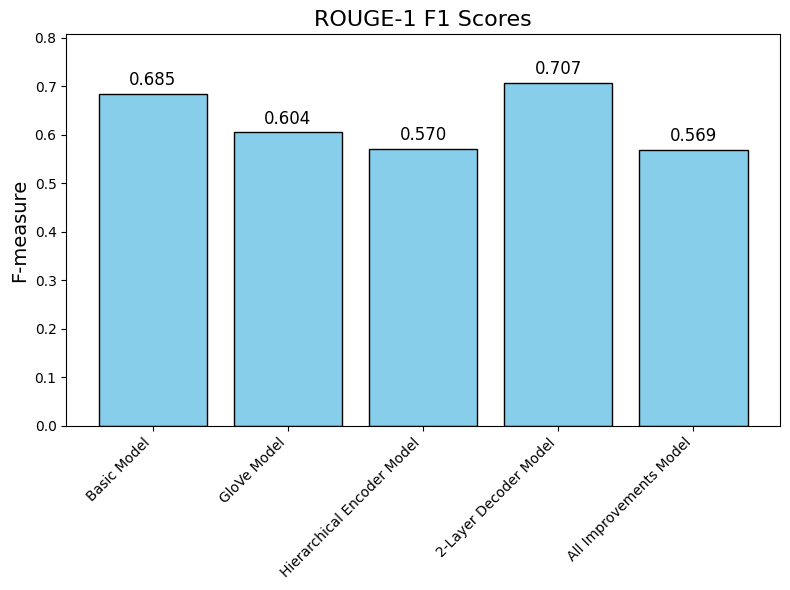

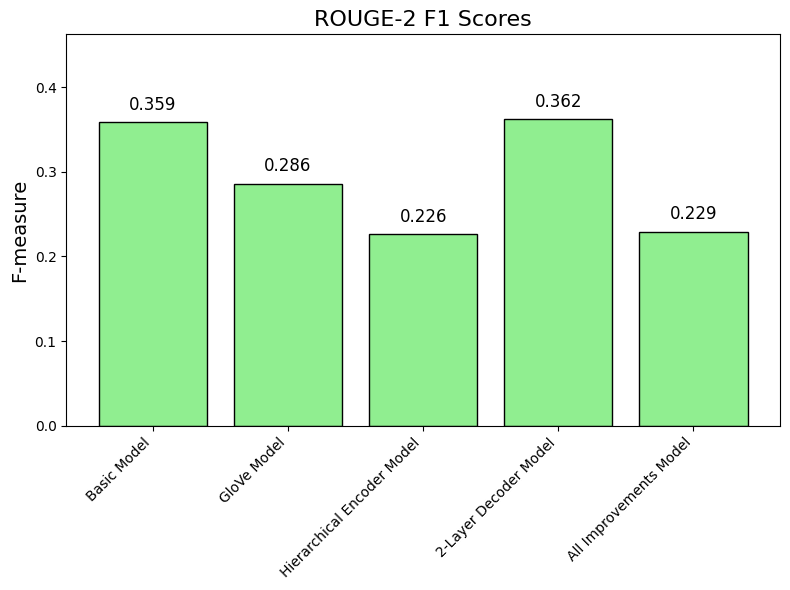

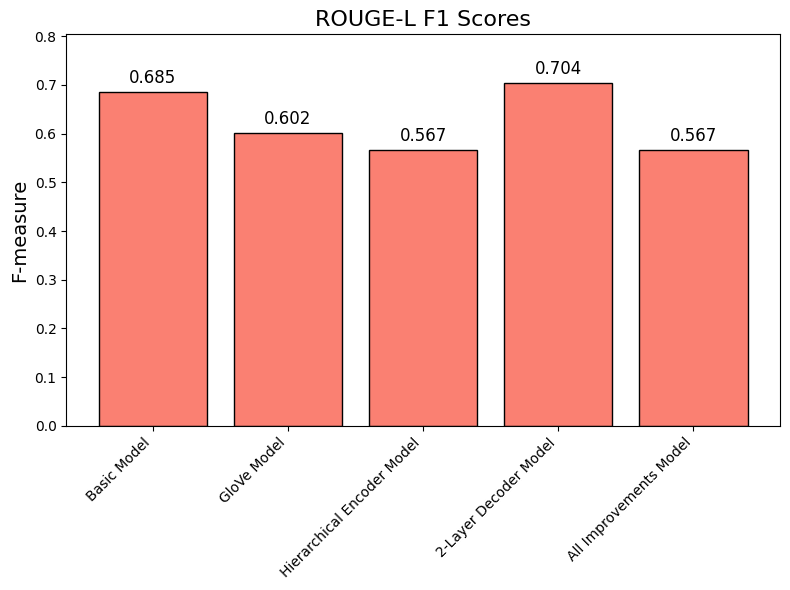

In [16]:
import matplotlib.pyplot as plt
import numpy as np

model_names  = [res["model"] for res in results]
rouge1_scores = [res["rouge"]["rouge1"] for res in results]
rouge2_scores = [res["rouge"]["rouge2"] for res in results]
rougeL_scores = [res["rouge"]["rougeL"] for res in results]

print("Model Names:", model_names)
print("ROUGE-1:", rouge1_scores)
print("ROUGE-2:", rouge2_scores)
print("ROUGE-L:", rougeL_scores)

# --- Plot for ROUGE-1 ---
plt.figure(figsize=(8, 6))
plt.bar(model_names, rouge1_scores, color='skyblue', edgecolor='black')
plt.title("ROUGE-1 F1 Scores", fontsize=16)
plt.ylabel("F-measure", fontsize=14)
plt.ylim(0, max(rouge1_scores) + 0.1)
plt.xticks(rotation=45, ha='right')

for i, score in enumerate(rouge1_scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# --- Plot for ROUGE-2 ---
plt.figure(figsize=(8, 6))
plt.bar(model_names, rouge2_scores, color='lightgreen', edgecolor='black')
plt.title("ROUGE-2 F1 Scores", fontsize=16)
plt.ylabel("F-measure", fontsize=14)
plt.ylim(0, max(rouge2_scores) + 0.1)
plt.xticks(rotation=45, ha='right')

for i, score in enumerate(rouge2_scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# --- Plot for ROUGE-L ---
plt.figure(figsize=(8, 6))
plt.bar(model_names, rougeL_scores, color='salmon', edgecolor='black')
plt.title("ROUGE-L F1 Scores", fontsize=16)
plt.ylabel("F-measure", fontsize=14)
plt.ylim(0, max(rougeL_scores) + 0.1)
plt.xticks(rotation=45, ha='right')

for i, score in enumerate(rougeL_scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()
